In [96]:
import torch
import torch.nn as nn
from utils.dataset import BikeDataModule
from models.mlp import MLP
from models.lstm import LSTMModel
from config import (
    CSV_PATH,
    PREPROCESSOR_PATH,
    y_SCALER_PATH,
    LOGS_DIR,
    BATCH_SIZE,
    EPOCHS,
    WINDOW,
    LR,
    TEST_SIZE,
    VAL_SIZE,
    WEIGHTS_PATH_MLP,
    WEIGHTS_PATH_LSTM
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [97]:
## Setting the theme for plots
sns.set_theme(
    style="darkgrid",
    context="talk",      # larger fonts for presentations
    font_scale=0.9
)

plt.rcParams.update({
    "figure.figsize": (10, 5),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
})

In [98]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Testing

In [99]:
def evaluate_with_preds(model, loader, criterion):
    model.eval()

    total_loss = 0.0
    preds_all = []
    y_all = []

    with torch.no_grad():
        for X, y in loader:
            X = X.to(DEVICE)
            y = y.to(DEVICE)

            preds = model(X)
            loss = criterion(preds, y)

            total_loss += loss.item() * X.size(0)

            preds_all.append(preds.cpu().numpy())
            y_all.append(y.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)

    preds_all = np.vstack(preds_all)
    y_all = np.vstack(y_all)

    return avg_loss, preds_all, y_all

In [100]:
def test_mlp():
    dm = BikeDataModule(
        csv_path=CSV_PATH,
        test_size=TEST_SIZE,
        val_size=VAL_SIZE,
        batch_size=BATCH_SIZE,
        window=WINDOW,
        x_preprocessor_path=PREPROCESSOR_PATH,
        y_scaler_path=y_SCALER_PATH
    )

    test_loader = dm.mlp_test_loader()
    input_dim = next(iter(test_loader))[0].shape[1]

    model = MLP(input_dim=input_dim).to(DEVICE)
    model.load_state_dict(torch.load(WEIGHTS_PATH_MLP, map_location=DEVICE))
    model.eval()

    criterion = nn.MSELoss()

    # ---- scaled predictions ----
    test_loss, y_pred_scaled, y_true_scaled = evaluate_with_preds(
        model, test_loader, criterion
    )

    # ---- load saved y scaler ----
    y_scaler = joblib.load(y_SCALER_PATH)

    # ---- inverse transform to real scale ----
    y_pred_real = y_scaler.inverse_transform(y_pred_scaled).ravel()
    y_true_real = y_scaler.inverse_transform(y_true_scaled).ravel()

    # ---- REAL RMSE (bike count) ----
    rmse_real = np.sqrt(((y_pred_real - y_true_real) ** 2).mean())

    print(f"Test RMSE (real scale): {rmse_real:.2f} bikes")
    print(f"Test MSE (scaled space): {test_loss:.4f}")

    # ---- plotting (real scale) ----
    x = np.arange(len(y_true_real))

    plt.figure(figsize=(12, 5))
    sns.lineplot(x=x, y=y_true_real, label="Actual")
    sns.lineplot(x=x, y=y_pred_real, label="Predicted")
    plt.title("MLP – Actual vs Predicted Bike Rentals (Test Set)")
    plt.xlabel("Time Index")
    plt.ylabel("Bike Count")
    plt.tight_layout()

    plt.savefig(
        "assets/model_results/mlp_actual_vs_predicted.svg",
        format="svg",
        transparent=True
    )
    plt.savefig(
        "assets/model_results/mlp_actual_vs_predicted_bg.svg",
        format="svg",
        facecolor="white"
    )
    
    plt.show()

In [101]:
def test_lstm():
    dm = BikeDataModule(
        csv_path=CSV_PATH,
        test_size=TEST_SIZE,
        val_size=VAL_SIZE,
        batch_size=BATCH_SIZE,
        window=WINDOW,
        x_preprocessor_path=PREPROCESSOR_PATH,
        y_scaler_path=y_SCALER_PATH
    )

    test_loader = dm.lstm_test_loader()

    # input_dim = feature dimension (last axis)
    input_dim = next(iter(test_loader))[0].shape[2]

    model = LSTMModel(
        input_dim=input_dim,
        hidden_dim=64,
        num_layers=1
    ).to(DEVICE)

    model.load_state_dict(torch.load(WEIGHTS_PATH_LSTM, map_location=DEVICE))
    model.eval()

    criterion = nn.MSELoss()

    # ---- scaled predictions ----
    test_loss, y_pred_scaled, y_true_scaled = evaluate_with_preds(
        model, test_loader, criterion
    )

    # ---- load saved y scaler ----
    y_scaler = joblib.load(y_SCALER_PATH)

    # ---- inverse transform to real scale ----
    y_pred_real = y_scaler.inverse_transform(y_pred_scaled).ravel()
    y_true_real = y_scaler.inverse_transform(y_true_scaled).ravel()

    # ---- REAL RMSE ----
    rmse_real = np.sqrt(((y_pred_real - y_true_real) ** 2).mean())

    print(f"LSTM Test RMSE (real scale): {rmse_real:.2f} bikes")
    print(f"LSTM Test MSE (scaled space): {test_loss:.4f}")

    # ---- plotting ----
    x = np.arange(len(y_true_real))

    plt.figure(figsize=(12, 5))
    sns.lineplot(x=x, y=y_true_real, label="Actual")
    sns.lineplot(x=x, y=y_pred_real, label="Predicted")
    plt.title("LSTM – Actual vs Predicted Bike Rentals (Test Set)")
    plt.xlabel("Time Index")
    plt.ylabel("Bike Count")
    plt.tight_layout()
    
    plt.savefig(
        "assets/model_results/lstm_actual_vs_predicted.svg",
        format="svg",
        transparent=True
    )
    plt.savefig(
        "assets/model_results/lstm_actual_vs_predicted_bg.svg",
        format="svg",
        facecolor="white"
    )
    
    plt.show()

Test RMSE (real scale): 77.86 bikes
Test MSE (scaled space): 0.2604


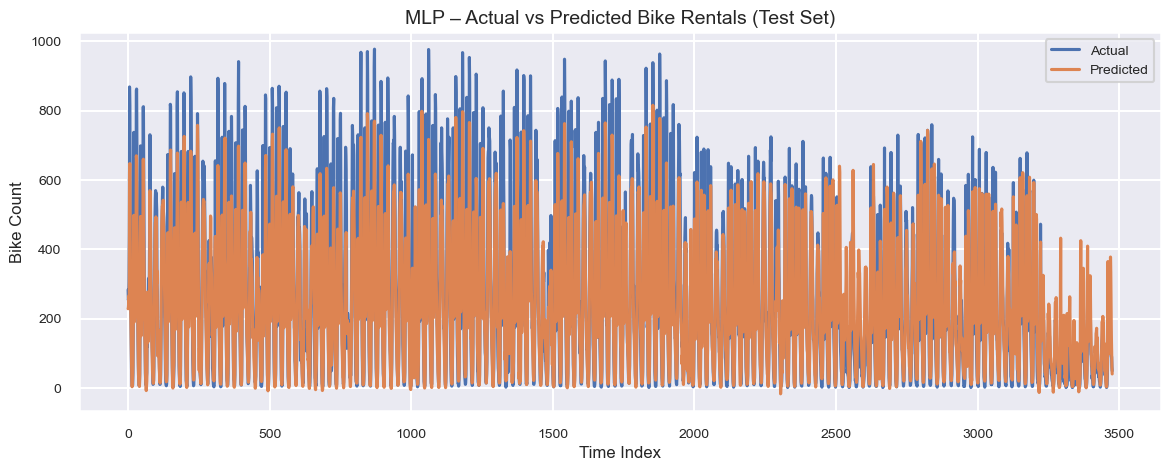

In [102]:
test_mlp()

LSTM Test RMSE (real scale): 69.11 bikes
LSTM Test MSE (scaled space): 0.2052


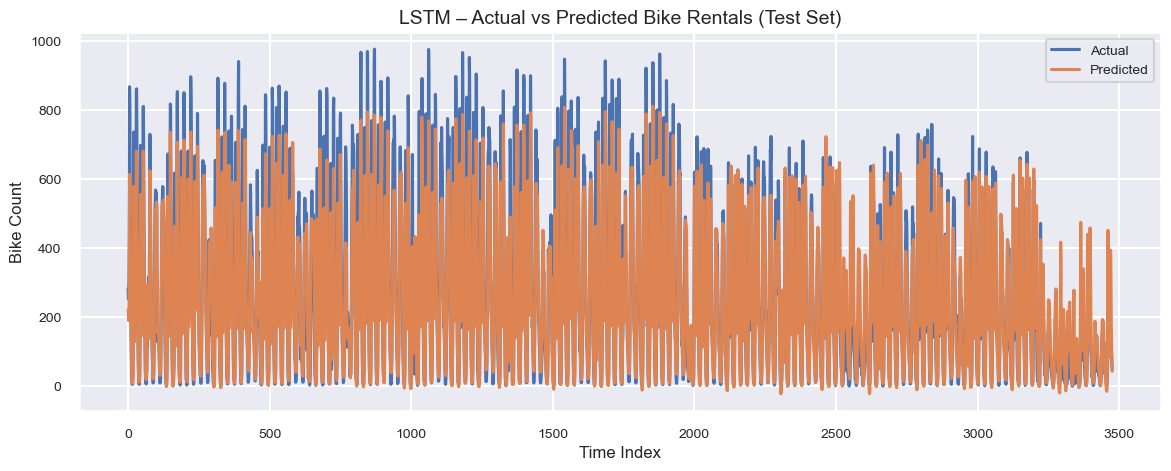

In [103]:
test_lstm()

# History Plot

In [104]:
mlp_hist = joblib.load("logs/mlp_hist.pkl")
lstm_hist = joblib.load("logs/lstm_hist.pkl")

epochs_mlp = np.arange(len(mlp_hist["train_loss"]))
epochs_lstm = np.arange(len(lstm_hist["train_loss"]))

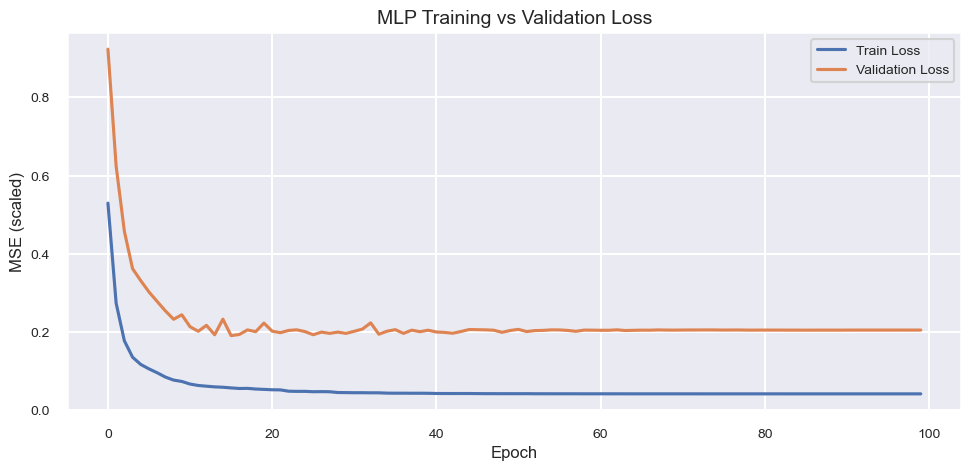

In [105]:
sns.lineplot(x=epochs_mlp, y=mlp_hist["train_loss"], label="Train Loss")
sns.lineplot(x=epochs_mlp, y=mlp_hist["val_loss"], label="Validation Loss")
plt.title("MLP Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE (scaled)")
plt.tight_layout()

plt.savefig(
    "assets/model_results/mlp_train_val_loss.svg",
    format="svg",
    transparent=True
)
plt.savefig(
    "assets/model_results/mlp_train_val_loss_bg.svg",
    format="svg",
    facecolor="white"
)

plt.show()

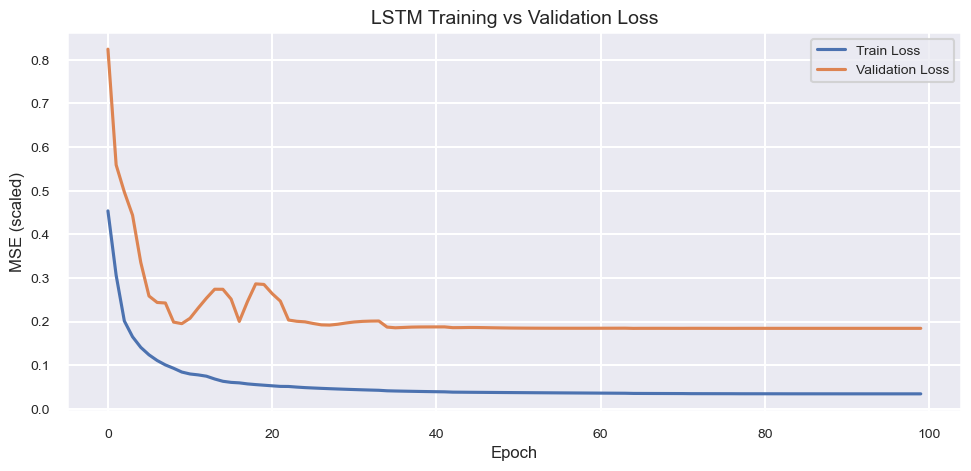

In [106]:
sns.lineplot(x=epochs_lstm, y=lstm_hist["train_loss"], label="Train Loss")
sns.lineplot(x=epochs_lstm, y=lstm_hist["val_loss"], label="Validation Loss")
plt.title("LSTM Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE (scaled)")
plt.tight_layout()

plt.savefig(
    "assets/model_results/lstm_train_val_loss.svg",
    format="svg",
    transparent=True
)
plt.savefig(
    "assets/model_results/lstm_train_val_loss_bg.svg",
    format="svg",
    facecolor="white"
)

plt.show()